In [1]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from collections import Counter
import statsmodels.api as sm
from adjustText import adjust_text
from scipy.stats import mannwhitneyu, permutation_test
from statsmodels.stats.multitest import multipletests
from itertools import product, combinations
from sklearn.utils import resample
from scipy.stats import pearsonr, norm, ttest_1samp
from joblib import Parallel, delayed
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

print(os.getcwd())
# os.chdir('../')
print(os.getcwd())

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/Python
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Step 1: Structural Comparison

In [2]:
df = pd.read_csv('./Output/super_May22/mm_data_agg.csv')

In [3]:
# Descriptive statistics
df.columns



Index(['Pair_Speaker_turn', 'PairID', 'PersonID', 'Speaker',
       'Speaker_original', 'Turn', 'Word', 'StartTime', 'EndTime',
       'Backchannel', 'Overlap', 'Contested', 'Duration',
       'Negotiation_Category', 'Conflict', 'team_viability', 'Sentiment',
       'word_count', 'Acknowledgement', 'Affirmation', 'Agreement', 'Apology',
       'Ask_Agency', 'By_The_Way', 'Can_You', 'Conjunction_Start', 'Could_You',
       'Disagreement', 'Filler_Pause', 'First_Person_Plural',
       'First_Person_Single', 'For_Me', 'For_You', 'Formal_Title',
       'Give_Agency', 'Goodbye', 'Gratitude', 'Hedges', 'Hello',
       'Impersonal_Pronoun', 'Informal_Title', 'Let_Me_Know', 'Negation',
       'Negative_Emotion', 'Please', 'Positive_Emotion', 'Reasoning',
       'Reassurance', 'Second_Person', 'Subjectivity', 'Swearing',
       'Truth_Intensifier', 'Bare_Command', 'YesNo_Questions', 'WH_Questions',
       'Adverb_Limiter', 'Token_count', 'Pitch', 'Vocal Intensity',
       'Vocal Articulation', 

In [4]:

# Compute correlation
r, p = pearsonr(df['Sentiment'], df['Conflict'])

# Print results
print(f"Pearson correlation: r = {r:.2f}, p = {p:.4f}")

Pearson correlation: r = -0.08, p = 0.0000


In [5]:
def structural_comparison(df):
    """
    Aggregates conversation-level metrics and plots structural differences across negotiation categories.
    """
    category_colors = {
        "Friendly": "#1F77B4",
        "Constructive": "#FF7F0E",
        "Apathetic": "#7F7F7F",
        "Destructive": "#D62728"
    }

    # Ensure datetime format
    # df["StartTime"] = pd.to_datetime(df["StartTime"])
    # df["EndTime"] = pd.to_datetime(df["EndTime"])

    # Compute conversation-level features
    convo_df = df.groupby("PairID").agg({
        "Negotiation_Category": "first",
        "Turn": "max",
        "Contested": lambda x: (x > 0).sum(),
        "Sentiment": "mean",
        "Conflict": "mean",
        "team_viability": "mean",
        "word_count": "mean",
        "StartTime": "min",
        "EndTime": "max"
    }).rename(columns={
        "Turn": "Avg. No. of Turns",
        "Contested": "Avg. Prop. Contested Turns",
        "Sentiment": "Avg. Sentiment",
        "word_count": "Avg. Word Count per Turn",
        "Conflict": "Conflict",
        "team_viability": "team_viability",
        "StartTime": "Start_time",
        "EndTime": "End_time"
    }).reset_index()

    # Compute duration
    convo_df["Duration (min)"] = (convo_df["End_time"] - convo_df["Start_time"]) / 60

    # Melt relevant metrics for mean and SD
    melted = convo_df.melt(
        id_vars="Negotiation_Category",
        value_vars=[
            "Avg. No. of Turns",
            "Avg. Prop. Contested Turns",
            "Avg. Sentiment",
            "Avg. Word Count per Turn",
            "Duration (min)",
            "Conflict",
            "team_viability"
        ],
        var_name="Metric",
        value_name="Value"
    )

    # Compute summary stats
    summary = melted.groupby(["Negotiation_Category", "Metric"]).agg(
        Mean_Value=("Value", "mean"),
        SD=("Value", "std"),
        Std_Error=("Value", lambda x: x.std() / np.sqrt(len(x)))
    ).reset_index()

    # Format as Mean (SD)
    summary["Mean (SD)"] = summary.apply(
        lambda row: f"{row['Mean_Value']:.2f} ({row['SD']:.2f})", axis=1
    )

    # Pivot to wide format: metrics as columns
    summary_wide = summary.pivot(index="Negotiation_Category", columns="Metric", values="Mean (SD)").reset_index()

    # Add number of conversations
    n_convos = convo_df.groupby("Negotiation_Category")["PairID"].count().reset_index(name="N Conversations")
    summary_wide = pd.merge(summary_wide, n_convos, on="Negotiation_Category")

    # Optional: reorder columns
    metric_order = [
        "Negotiation_Category", "N Conversations",
        "Avg. No. of Turns", "Avg. Prop. Contested Turns", 
        "Avg. Sentiment", "Avg. Word Count per Turn", "Duration (min)",
        "Conflict", "team_viability"
    ]
    summary_wide = summary_wide[[col for col in metric_order if col in summary_wide.columns]]

    # # Create point plots with improved aesthetics
    # sns.set(style="white", font_scale=1.8)
    # plt.rcParams['ytick.major.size'] = 4
    # plt.rcParams['ytick.minor.size'] = 2
    # plt.rcParams['ytick.direction'] = 'out'
    # fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, gridspec_kw={'hspace': 0.6})
    
    # metrics = summary["Metric"].unique()
    # axes = axes.flatten()

    # for i, metric in enumerate(metrics):
    #     ax = axes[i]
    #     metric_data = summary[summary["Metric"] == metric]
    #     sorted_categories = metric_data["Negotiation_Category"].tolist()
    #     colors = [category_colors[cat] for cat in sorted_categories]

    #     sns.pointplot(
    #         y="Negotiation_Category", x="Mean_Value", data=metric_data,
    #         hue="Negotiation_Category", palette=category_colors, dodge=False,
    #         errorbar=None, markers="o", linestyles="", ax=ax, markersize=12
    #     )

    #     for _, row in metric_data.iterrows():
    #         y_pos = metric_data["Negotiation_Category"].tolist().index(row["Negotiation_Category"])
    #         ax.errorbar(
    #         x=row["Mean_Value"],
    #         y=y_pos,
    #             xerr=row["Std_Error"],
    #             fmt='none', ecolor=category_colors[row["Negotiation_Category"]], capsize=5, lw=2
    #         )

    #     ax.set_title(metric.replace("_", " "), fontsize=18, weight='semibold', pad=20)
    #     ax.set_xlabel("")
    #     if i % 2 == 0:
    #         ax.set_yticklabels(metric_data["Negotiation_Category"].tolist(), fontsize=18)
    #     else:
    #         ax.tick_params(axis='y', which='major', length=6)
    #         ax.set_yticklabels([])  # This hides labels but not the ticks

    #     ax.tick_params(axis='y', which='both', length=6)
    #     ax.set_ylabel("")
    #     ax.spines['top'].set_visible(False)
    #     ax.spines['right'].set_visible(False)
    #     ax.tick_params(axis='y', which='both', length=6)

    
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.show()

    return summary_wide

# Call this function using:
# structural_comparison(df)


In [6]:
summary_table = structural_comparison(df)
summary_table

,Negotiation_Category,N Conversations,Avg. No. of Turns,Avg. Prop. Contested Turns,Avg. Sentiment,Avg. Word Count per Turn,Duration (min),Conflict,team_viability
0,Apathetic,6,55.50 (55.67),29.50 (30.99),0.13 (0.04),22.11 (11.99),13.28 (8.06),3.19 (0.30),4.79 (0.62)
1,Constructive,10,64.40 (25.50),41.10 (18.89),0.13 (0.02),25.25 (9.80),20.61 (8.39),4.05 (0.37),6.08 (0.35)
2,Destructive,13,68.85 (31.60),51.23 (45.68),0.12 (0.05),24.30 (7.99),20.62 (7.74),4.54 (0.58),4.75 (0.91)
3,Friendly,14,61.86 (21.70),42.93 (22.73),0.15 (0.04),21.35 (5.47),18.79 (5.96),3.12 (0.45),6.57 (0.45)


Step 2: Behavioral Patterns before Contested Turns


In [7]:

def prepare_dataset(df, negotiation_category, n_prior_turns=1):

    if negotiation_category == "All":
        df_cat = df.copy()
    else:
        df_cat = df[df['Negotiation_Category'] == negotiation_category].copy()
    
    df_cat = df_cat.sort_values(by=['PairID', 'Turn']).reset_index(drop=True)
    df_cat['Label'] = 0
    contested_idx = df_cat[df_cat['Contested'] > 0].index

    for idx in contested_idx:
        if idx - n_prior_turns >= 0:
            prior_idx = idx - n_prior_turns
            same_pair = df_cat.loc[prior_idx, 'PairID'] == df_cat.loc[idx, 'PairID']
            if same_pair and df_cat.loc[prior_idx, 'Contested'] == 0:
                df_cat.loc[prior_idx, 'Label'] = 1

    df_filtered = df_cat[df_cat['Contested'] == 0]
    raw_behavior_cols = df.columns[df.columns.get_loc("Acknowledgement"):df.columns.get_loc("Smile") + 1]
    rename_map = {col: col.replace('_', ' ').title() for col in raw_behavior_cols}
    df.rename(columns=rename_map, inplace=True)
    behavior_cols = list(rename_map.values())
    return df_filtered, behavior_cols

def train_xgboost_and_get_shap(df_filtered, behavior_cols):
    X = df_filtered[behavior_cols]
    y = df_filtered['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
    return model, X, y, shap_values

def get_feature_modalities(X_columns):
    vocal_feats = ["Pitch", "Vocal Intensity", "Vocal Articulation", "Vocal Clarity"]
    visual_feats = ["Squint Puff Sneer", "Compressed Contortion", "Brow Up", "Cheek Puff Sneer",
                    "Blink", "Look Down", "Look Right", "Look Left", "Look Up", "Blink Right",
                    "Eyes Wide", "Open Mouth", "Jaw Left", "Jaw Right", "Mouthclose_Openjaw",
                    "Mouthdimple Left", "Mouthdimple Right", "Skeptical Right", "Sneering Pucker",
                    "Mouth Right", "Mouth Roll", "Mouth Shrug", "Smile"]
    linguistic_feats = [f for f in X_columns if f not in vocal_feats + visual_feats]
    return linguistic_feats, vocal_feats, visual_feats

def get_top_shap_features(shap_values, X, top_n=20):
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    mean_abs_shap = shap_df.abs().mean()
    return mean_abs_shap.sort_values(ascending=False).head(top_n).index.tolist()

def plot_shap_summary(shap_values, X):
    shap.summary_plot(shap_values, X, plot_type="dot", show=False, plot_size=(10, 10))
    plt.xlabel("SHAP Values:\n← More Predictive of Non-Contested Turn | More Predictive of Pre-Contested Turn →", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_shap_scatter(shap_values, X, y):
    linguistic_feats, vocal_feats, facial_feats = get_feature_modalities(X.columns)

    shap_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP Non-Contested': np.mean(np.abs(shap_values.values[y == 0]), axis=0),
        'SHAP Pre-Contested': np.mean(np.abs(shap_values.values[y == 1]), axis=0)
    })

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in facial_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    shap_df['Modality'] = shap_df['Feature'].apply(get_modality)
    shap_df['Diff'] = shap_df['SHAP Pre-Contested'] - shap_df['SHAP Non-Contested']
    threshold = 0.03
    shap_df['Label'] = shap_df.apply(lambda row: row['Feature'] if abs(row['Diff']) > threshold else '', axis=1)

    plt.figure(figsize=(14, 6))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=shap_df, x='SHAP Non-Contested', y='SHAP Pre-Contested', hue='Modality', palette=palette, s=100, alpha=0.7)
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel('SHAP Value (Non-Contested)')
    plt.ylabel('SHAP Value (Pre-Contested)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

    texts = []
    for _, row in shap_df[shap_df['Label'] != ''].iterrows():
        texts.append(plt.text(row['SHAP Non-Contested'], row['SHAP Pre-Contested'], row['Label'], fontsize=10, weight='bold', color='black'))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'), expand_points=(2, 2), expand_text=(2, 2), force_text=0.7)

    plt.tight_layout()
    plt.show()

def compute_bootstrapped_shap_se(model, X, n_bootstraps=100, random_state=42):
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    mean_shap_values_boot = np.zeros((n_bootstraps, n_features))
    explainer = shap.TreeExplainer(model)

    for i in range(n_bootstraps):
        X_boot = resample(X, n_samples=n_samples, replace=True, random_state=random_state + i)
        shap_values_boot = explainer(X_boot).values
        mean_shap_values_boot[i, :] = np.mean(np.abs(shap_values_boot), axis=0)

    mean_shap = mean_shap_values_boot.mean(axis=0)
    se_shap = mean_shap_values_boot.std(axis=0, ddof=1)

    return pd.DataFrame({
        'Feature': X.columns,
        'Mean SHAP (Boot)': mean_shap,
        'Boot SE': se_shap
    })

def plot_bootstrapped_shap(boot_df, X_columns):
    linguistic_feats, vocal_feats, visual_feats = get_feature_modalities(X_columns)

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in visual_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    boot_df['Modality'] = boot_df['Feature'].apply(get_modality)
    boot_df = boot_df[~((boot_df['Mean SHAP (Boot)'] == 0) & (boot_df['Boot SE'] == 0))]
    boot_df = boot_df.sort_values(by='Mean SHAP (Boot)', ascending=False)
    
    num_features = boot_df.shape[0]
    spacing_factor = 0.35
    y_pos = np.arange(num_features)[::-1] * spacing_factor

    plt.figure(figsize=(12, spacing_factor * num_features + 0.5))
    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    sns.scatterplot(data=boot_df, x='Mean SHAP (Boot)', y=y_pos, hue='Modality', palette=palette, s=80)

    for i, (_, row) in enumerate(boot_df.iterrows()):
        color = palette[row['Modality']]
        plt.plot([row['Mean SHAP (Boot)'] - row['Boot SE'], row['Mean SHAP (Boot)'] + row['Boot SE']],
                 [y_pos[i], y_pos[i]], color=color, linewidth=1.5)
        plt.plot([row['Mean SHAP (Boot)'] - row['Boot SE'], row['Mean SHAP (Boot)'] - row['Boot SE']],
                 [y_pos[i] - 0.05, y_pos[i] + 0.05], color=color, linewidth=1)
        plt.plot([row['Mean SHAP (Boot)'] + row['Boot SE'], row['Mean SHAP (Boot)'] + row['Boot SE']],
                 [y_pos[i] - 0.05, y_pos[i] + 0.05], color=color, linewidth=1)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.yticks(y_pos, boot_df['Feature'], fontsize=14)
    plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.5)

    plt.tick_params(axis='y', pad=3)
    plt.xticks(fontsize=18)
    plt.xlabel("Mean Absolute SHAP Values (±1 SE, Bootstrapped)", fontsize=18)
    # plt.title("Predictive Features for Pre-Contested Turns", fontsize=15, pad=15)
    plt.ylim(y_pos.min() - spacing_factor / 2, y_pos.max() + spacing_factor / 2)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tick_params(axis='x', colors='black')

    plt.show()

    return boot_df[['Feature', 'Modality', 'Mean SHAP (Boot)', 'Boot SE']].reset_index(drop=True)

def generate_categorywise_bootstrapped_shap(df, segment_names, n_boot=100):
    """
    generate a dictionary of bootstrapped SHAP value DataFrames
    for each segment (category), with modality added.
    """
    shap_dfs = {}

    for segment in segment_names:
        df_filtered, behavior_cols = prepare_dataset(df, segment)
        model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
        boot_df = compute_bootstrapped_shap_se(model, X, n_bootstraps=n_boot)
        
        linguistic_feats, vocal_feats, visual_feats = get_feature_modalities(X.columns)

        def get_modality(feat):
            if feat in vocal_feats:
                return 'Vocal'
            elif feat in visual_feats:
                return 'Visual'
            else:
                return 'Linguistic'

        boot_df['Modality'] = boot_df['Feature'].apply(get_modality)
        boot_df = boot_df[~((boot_df['Mean SHAP (Boot)'] == 0) & (boot_df['Boot SE'] == 0))]
        shap_dfs[segment] = boot_df

    return shap_dfs


def plot_dumbbell_comparison(df_dict, category1, category2):
    """
    Plots a dumbbell plot comparing bootstrapped SHAP values between two categories.
    Parameters:
    - df_dict: Dictionary containing DataFrames for each category.
    - category1: Name of the first category.
    - category2: Name of the second category.
    Returns:
    - df_merged: Merged DataFrame with bootstrapped SHAP values and significance.
    """

    # Define colors
    category_colors = {
        category1: "#e3057e",  # pinkish
        category2: "#302d7e"   # purplish
    }

    # Input DataFrames
    df1 = df_dict[category1]
    df2 = df_dict[category2]

    # Merge on Feature
    df_merged = pd.merge(
        df1[['Feature', 'Mean SHAP (Boot)', 'Boot SE']],
        df2[['Feature', 'Mean SHAP (Boot)', 'Boot SE']],
        on='Feature',
        suffixes=(f'_{category1}', f'_{category2}')
    )

    # Average SHAP for sorting
    df_merged['Avg SHAP'] = df_merged[[f'Mean SHAP (Boot)_{category1}', f'Mean SHAP (Boot)_{category2}']].mean(axis=1)
    df_merged = df_merged.sort_values(by='Avg SHAP', ascending=True).reset_index(drop=True)

    # Significance via SE overlap
    se1 = df_merged[f'Boot SE_{category1}']
    se2 = df_merged[f'Boot SE_{category2}']
    diff = df_merged[f'Mean SHAP (Boot)_{category1}'] - df_merged[f'Mean SHAP (Boot)_{category2}']
    combined_se = np.sqrt(se1**2 + se2**2)
    df_merged['Significant'] = abs(diff) > 1.96 * combined_se

    # Plot
    spacing_factor = 0.4
    y_pos = np.arange(len(df_merged))
    plt.figure(figsize=(14, spacing_factor * len(df_merged) + 1))

    color1 = category_colors[category1]
    color2 = category_colors[category2]

    for i, row in df_merged.iterrows():
        y = y_pos[i]
        x1 = row[f'Mean SHAP (Boot)_{category1}']
        x2 = row[f'Mean SHAP (Boot)_{category2}']
        se1 = row[f'Boot SE_{category1}']
        se2 = row[f'Boot SE_{category2}']

        # Only draw line if significant
        if row['Significant']:
            plt.plot([x1, x2], [y, y], color='gray', linewidth=2.5, zorder=1)

        # Points with error bars
        plt.errorbar(x1, y, xerr=se1, fmt='o', color=color1, ecolor=color1, elinewidth=1.5, capsize=3, markersize=7, zorder=2)
        plt.errorbar(x2, y, xerr=se2, fmt='o', color=color2, ecolor=color2, elinewidth=1.5, capsize=3, markersize=7, zorder=2)

    plt.yticks(y_pos, df_merged['Feature'], fontsize=14)
    plt.xlabel("Mean Absolute SHAP Value", fontsize=20)
    plt.xticks(fontsize=20)
    plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.5)
    plt.ylim(-0.5, len(df_merged) - 0.5)

    # Remove borders
    ax = plt.gca()
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color=color1, linestyle='None', markersize=8, label=category1),
        Line2D([0], [0], marker='o', color=color2, linestyle='None', markersize=8, label=category2)
        # Line2D([0], [0], color='gray', linewidth=2.5, label='Significant Difference Only')
    ]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, fontsize=20)

    plt.tight_layout()
    plt.show()

    return df_merged[['Feature',
                      f'Mean SHAP (Boot)_{category1}', f'Boot SE_{category1}',
                      f'Mean SHAP (Boot)_{category2}', f'Boot SE_{category2}',
                      'Significant']]

def plot_dumbbell_facets(df_dict, base_category, compare_categories):
    """
    Plots dumbbell plots comparing bootstrapped SHAP values between a base category
    and multiple other categories as subplots (facets), and returns full results table.

    Parameters:
    - df_dict: Dictionary containing DataFrames for each category.
    - base_category: The category to compare others against (e.g., 'Constructive').
    - compare_categories: List of categories to compare with the base category.
    
    Returns:
    - A DataFrame with SHAP values, confidence intervals, and FDR-adjusted p-values.
    """

    modality_colors = {
        'Linguistic': '#1f77b4',
        'Vocal': '#ff7f0e',
        'Visual': '#2ca02c'
    }

    modality_map = dict(zip(df_dict[base_category]['Feature'], df_dict[base_category]['Modality']))
    n_facets = len(compare_categories)
    fig, axes = plt.subplots(1, n_facets, figsize=(6 * n_facets, 0.4 * len(df_dict[base_category]) + 2), sharey=True)
    if n_facets == 1:
        axes = [axes]

    base_df = df_dict[base_category].copy()
    feature_order = base_df.sort_values(by='Mean SHAP (Boot)')['Feature'].tolist()
    results = []

    for ax, compare_category in zip(axes, compare_categories):
        df1 = df_dict[base_category]
        df2 = df_dict[compare_category]

        df_merged = pd.merge(
            df1[['Feature', 'Mean SHAP (Boot)', 'Boot SE']],
            df2[['Feature', 'Mean SHAP (Boot)', 'Boot SE']],
            on='Feature',
            how='left',
            suffixes=(f'_{base_category}', f'_{compare_category}')
        )

        df_merged['Feature'] = pd.Categorical(df_merged['Feature'], categories=feature_order, ordered=True)
        df_merged = df_merged.sort_values('Feature').reset_index(drop=True)

        # Significance and CI calculations
        diff = df_merged[f'Mean SHAP (Boot)_{base_category}'] - df_merged[f'Mean SHAP (Boot)_{compare_category}']
        se1 = df_merged[f'Boot SE_{base_category}']
        se2 = df_merged[f'Boot SE_{compare_category}']
        combined_se = np.sqrt(se1**2 + se2**2)

        df_merged['z'] = diff / combined_se
        df_merged['p_value'] = 2 * (1 - norm.cdf(abs(df_merged['z'])))
        p_values = df_merged['p_value']
        mask_valid = ~p_values.isna()

        # Create empty array of NaNs
        pvals_corrected_full = [np.nan] * len(p_values)

        # Only apply FDR if there are valid p-values
        if mask_valid.sum() > 0:
            _, corrected = multipletests(p_values[mask_valid], method='fdr_bh')[:2]
            for i, idx in enumerate(p_values[mask_valid].index):
                pvals_corrected_full[idx] = corrected[i]

        df_merged['p_fdr'] = pvals_corrected_full


        z_crit = 1.96
        for cat in [base_category, compare_category]:
            df_merged[f'CI_lower_{cat}'] = df_merged[f'Mean SHAP (Boot)_{cat}'] - z_crit * df_merged[f'Boot SE_{cat}']
            df_merged[f'CI_upper_{cat}'] = df_merged[f'Mean SHAP (Boot)_{cat}'] + z_crit * df_merged[f'Boot SE_{cat}']

        df_merged['Comparison'] = f"{base_category} vs {compare_category}"
        results.append(df_merged)

        # Plotting
        y_pos = np.arange(len(df_merged))
        color1 = "#e3057e"
        color2 = "#302d7e"

        for i, row in df_merged.iterrows():
            y = y_pos[i]
            x1 = row[f'Mean SHAP (Boot)_{base_category}']
            x2 = row[f'Mean SHAP (Boot)_{compare_category}']
            se1 = row[f'Boot SE_{base_category}']
            se2 = row[f'Boot SE_{compare_category}']

            ax.errorbar(x1, y, xerr=se1, fmt='o', color=color1, ecolor=color1,
                        capsize=4, markersize=10, zorder=2)

            if pd.notna(x2):
                significant = abs(x1 - x2) > 1.96 * np.sqrt(se1**2 + se2**2)
                if significant:
                    ax.plot([x1, x2], [y, y], color='gray', linewidth=5, zorder=1)
                ax.errorbar(x2, y, xerr=se2, fmt='o', color=color2, ecolor=color2,
                            capsize=4, markersize=10, zorder=2)

        ax.set_title(f"{base_category} vs. {compare_category}", fontsize=20)
        ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.6, alpha=0.6)
        ax.set_xlim(left=0)
        ax.tick_params(axis='x', labelsize=18)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(df_merged['Feature'], fontsize=20)
        ax.tick_params(axis='y', length=0)

        for tick_label in ax.get_yticklabels():
            feat = tick_label.get_text()
            modality = modality_map.get(feat, None)
            tick_label.set_fontweight('bold')
            if modality:
                tick_label.set_color(modality_colors[modality])
            else:
                tick_label.set_color("black")

        for spine in ['top', 'right', 'left']:
            ax.spines[spine].set_visible(False)

    legend_elements = [
        Line2D([0], [0], marker='o', color=color1, linestyle='None', markersize=8, label=base_category),
        Line2D([0], [0], marker='o', color=color2, linestyle='None', markersize=8, label='Comparison')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.6, .98), ncol=2, frameon=False, fontsize=20)
    fig.text(0.6, -.02, "Mean Absolute SHAP Value", ha='center', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return pd.concat(results, ignore_index=True)

def compute_feature_dv_correlations(df, behavior_cols, dv1="Conflict", dv2="team_viability"):
    """
    Compute correlation coefficients and p-values between behavioral features and two DVs.
    Plot a scatterplot where:
    - Each point is a feature.
    - X = correlation with dv1
    - Y = correlation with dv2
    - Size = -log10(min p-value)
    - Color = Modality

    Returns:
    - corr_df: DataFrame with correlations, p-values, modality, and visual properties.
    """
    # Rename for display
    dv2_label = "Team Viability"

    # Get modalities
    linguistic_feats, vocal_feats, visual_feats = get_feature_modalities(behavior_cols)

    def get_modality(feat):
        if feat in vocal_feats:
            return 'Vocal'
        elif feat in visual_feats:
            return 'Visual'
        else:
            return 'Linguistic'

    # Compute correlations and p-values
    records = []
    for feat in behavior_cols:
        r1, p1 = pearsonr(df[feat], df[dv1])
        r2, p2 = pearsonr(df[feat], df[dv2])
        modality = get_modality(feat)
        records.append({
            'Feature': feat,
            f'r_{dv1}': r1, f'p_{dv1}': p1,
            f'r_{dv2}': r2, f'p_{dv2}': p2,
            'Modality': modality
        })

    corr_df = pd.DataFrame(records)

    # Compute plotting attributes
    corr_df['min_p'] = corr_df[[f'p_{dv1}', f'p_{dv2}']].min(axis=1).clip(lower=1e-10)
    corr_df['size'] = -np.log10(corr_df['min_p'])
    corr_df['importance'] = corr_df[f'r_{dv1}'].abs() + corr_df[f'r_{dv2}'].abs()

    # Select top features to label
    top_features = corr_df.sort_values('importance', ascending=False).head(12)['Feature'].tolist()

    # Plot
    import matplotlib.pyplot as plt
    import seaborn as sns
    # from adjustText import adjust_text  # Optional: install and uncomment if available

    palette = {'Linguistic': '#1f77b4', 'Vocal': '#ff7f0e', 'Visual': '#2ca02c'}
    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=corr_df,
        x=f'r_{dv1}', y=f'r_{dv2}',
        hue='Modality', palette=palette,
        size='size', sizes=(50, 400), alpha=0.8
    )

    texts = []
    for _, row in corr_df.iterrows():
        if row['Feature'] in top_features:
            texts.append(plt.text(row[f'r_{dv1}'], row[f'r_{dv2}'], row['Feature'], fontsize=9, weight='bold'))

    # Optional: uncomment if adjustText is installed
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.axhline(0, linestyle='--', color='gray', linewidth=0.7)
    plt.axvline(0, linestyle='--', color='gray', linewidth=0.7)
    plt.xlabel(f'Correlation with {dv1}')
    plt.ylabel(f'Correlation with {dv2_label}')
    plt.title('Feature Correlations with Conflict and Team Visibility')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    return corr_df.round(3)



Single category analysis

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:10:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/mn/8g_xs0bn0v72cpz81h487wj80000gp/T/ipykernel_3154/2963406382.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="dot", show=False, plot_size=(10, 10))


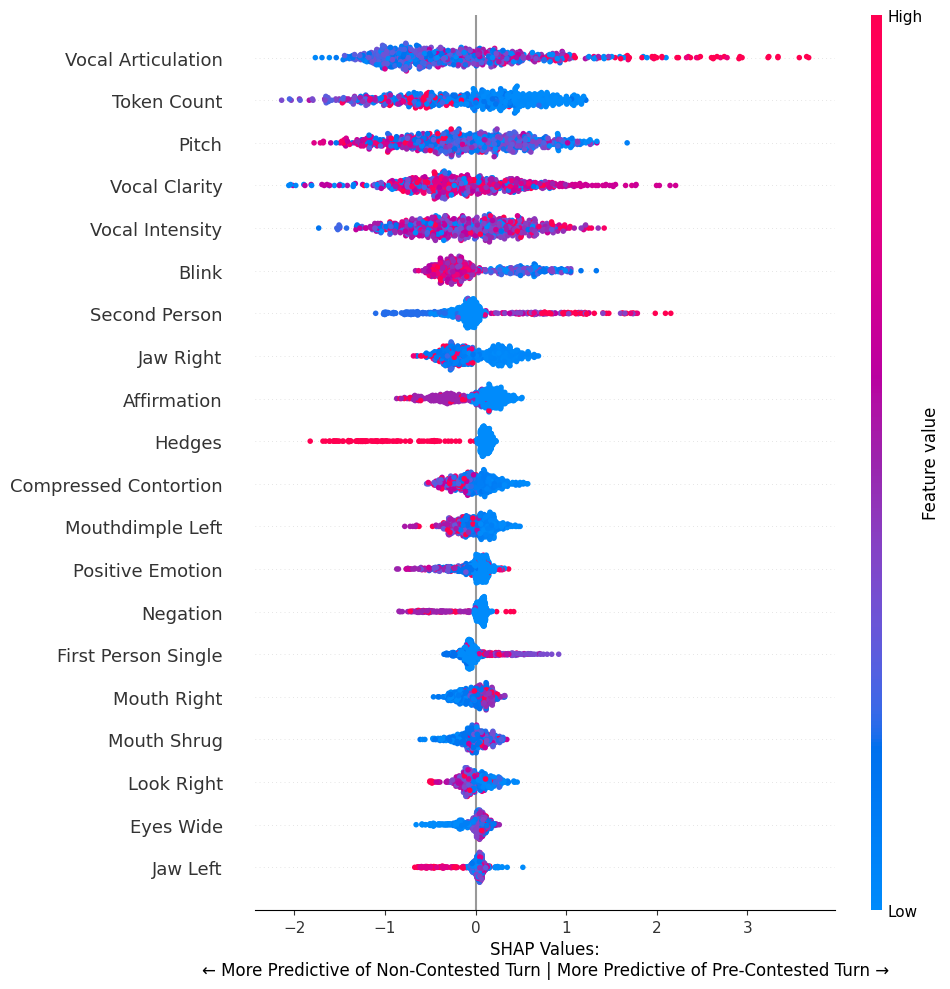

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


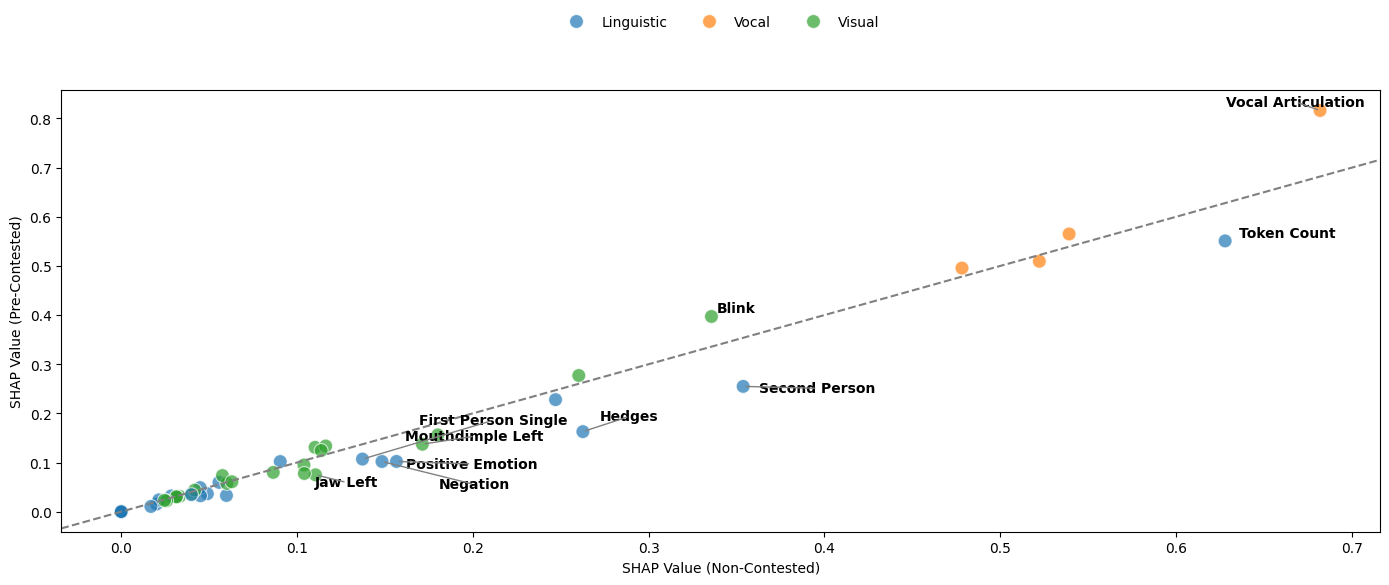

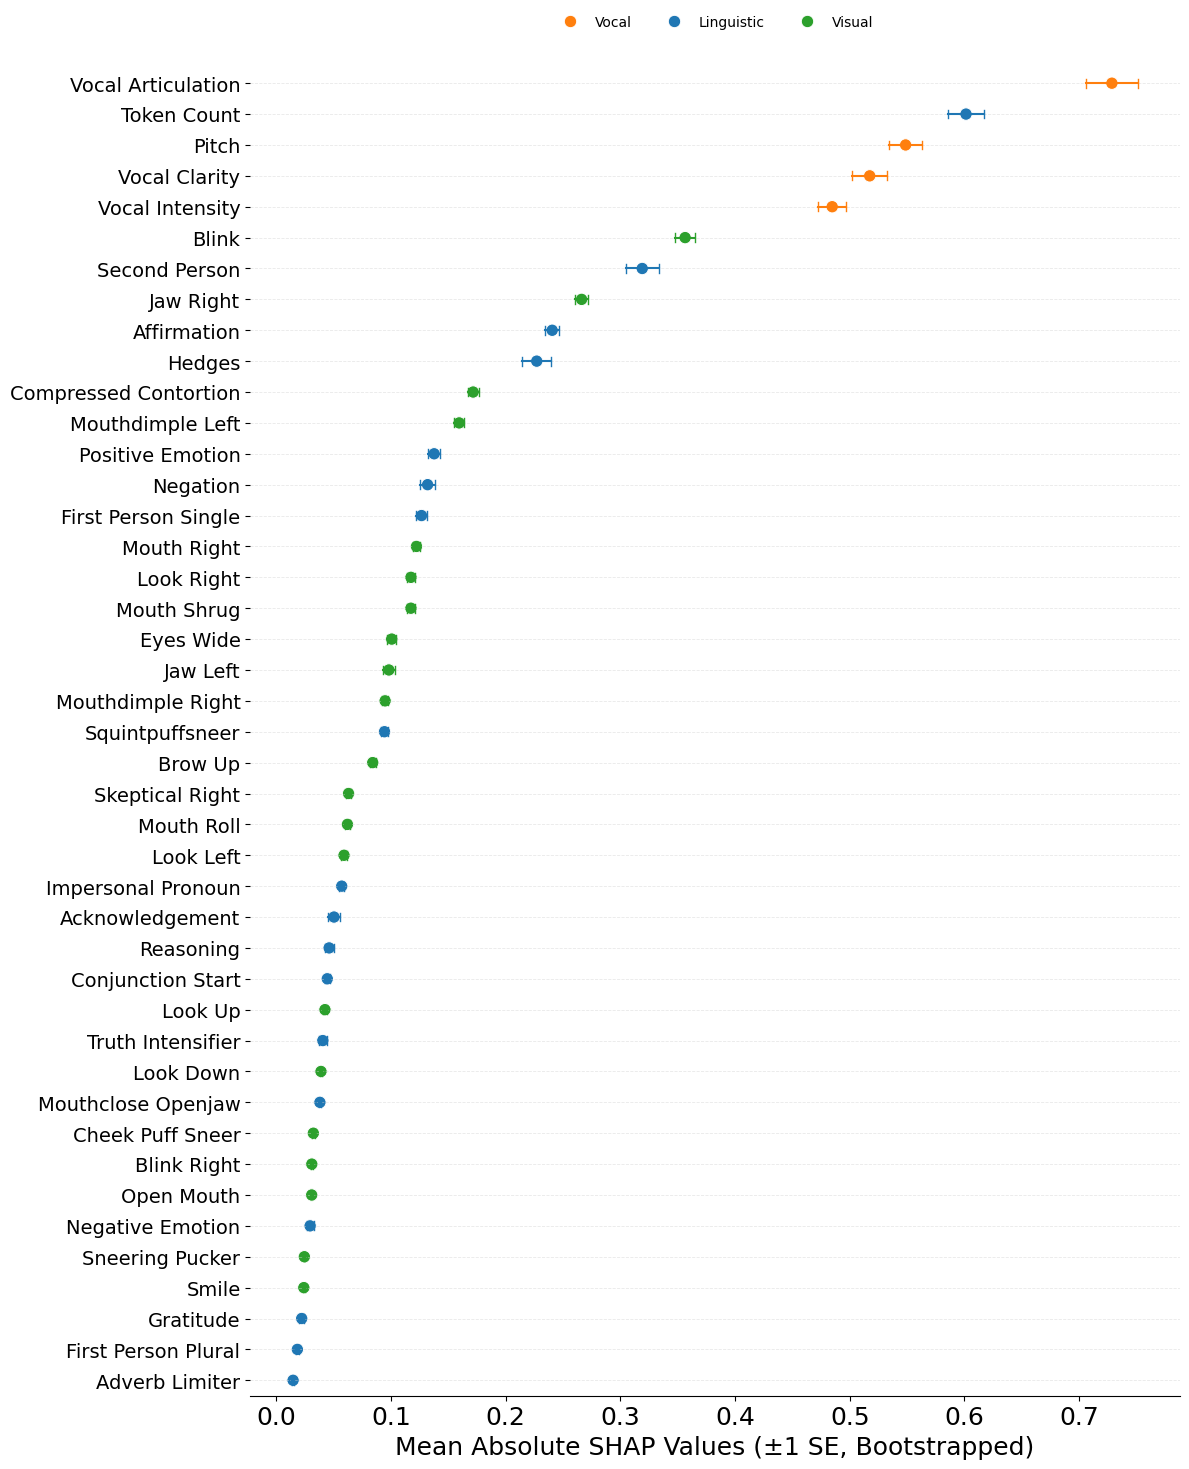

                  Feature    Modality  Mean SHAP (Boot)   Boot SE
0      Vocal Articulation       Vocal          0.728598  0.022510
1             Token Count  Linguistic          0.601409  0.015570
2                   Pitch       Vocal          0.548762  0.014691
3           Vocal Clarity       Vocal          0.517441  0.015442
4         Vocal Intensity       Vocal          0.484747  0.012425
5                   Blink      Visual          0.356521  0.008646
6           Second Person  Linguistic          0.319129  0.014584
7               Jaw Right      Visual          0.266276  0.005455
8             Affirmation  Linguistic          0.240622  0.006296
9                  Hedges  Linguistic          0.227139  0.012484
10  Compressed Contortion      Visual          0.171692  0.004704
11       Mouthdimple Left      Visual          0.159519  0.004338
12       Positive Emotion  Linguistic          0.137706  0.005439
13               Negation  Linguistic          0.132008  0.006662
14    Firs

In [10]:
df_filtered, behavior_cols = prepare_dataset(df, negotiation_category="Constructive")
model, X, y, shap_values = train_xgboost_and_get_shap(df_filtered, behavior_cols)
plot_shap_summary(shap_values, X)
plot_shap_scatter(shap_values, X, y)

bootstrapped_shap_df = compute_bootstrapped_shap_se(model, X, n_bootstraps=1000)

results_table = plot_bootstrapped_shap(bootstrapped_shap_df, X.columns)
print(results_table)


Comparative analysis

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:11:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:12:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


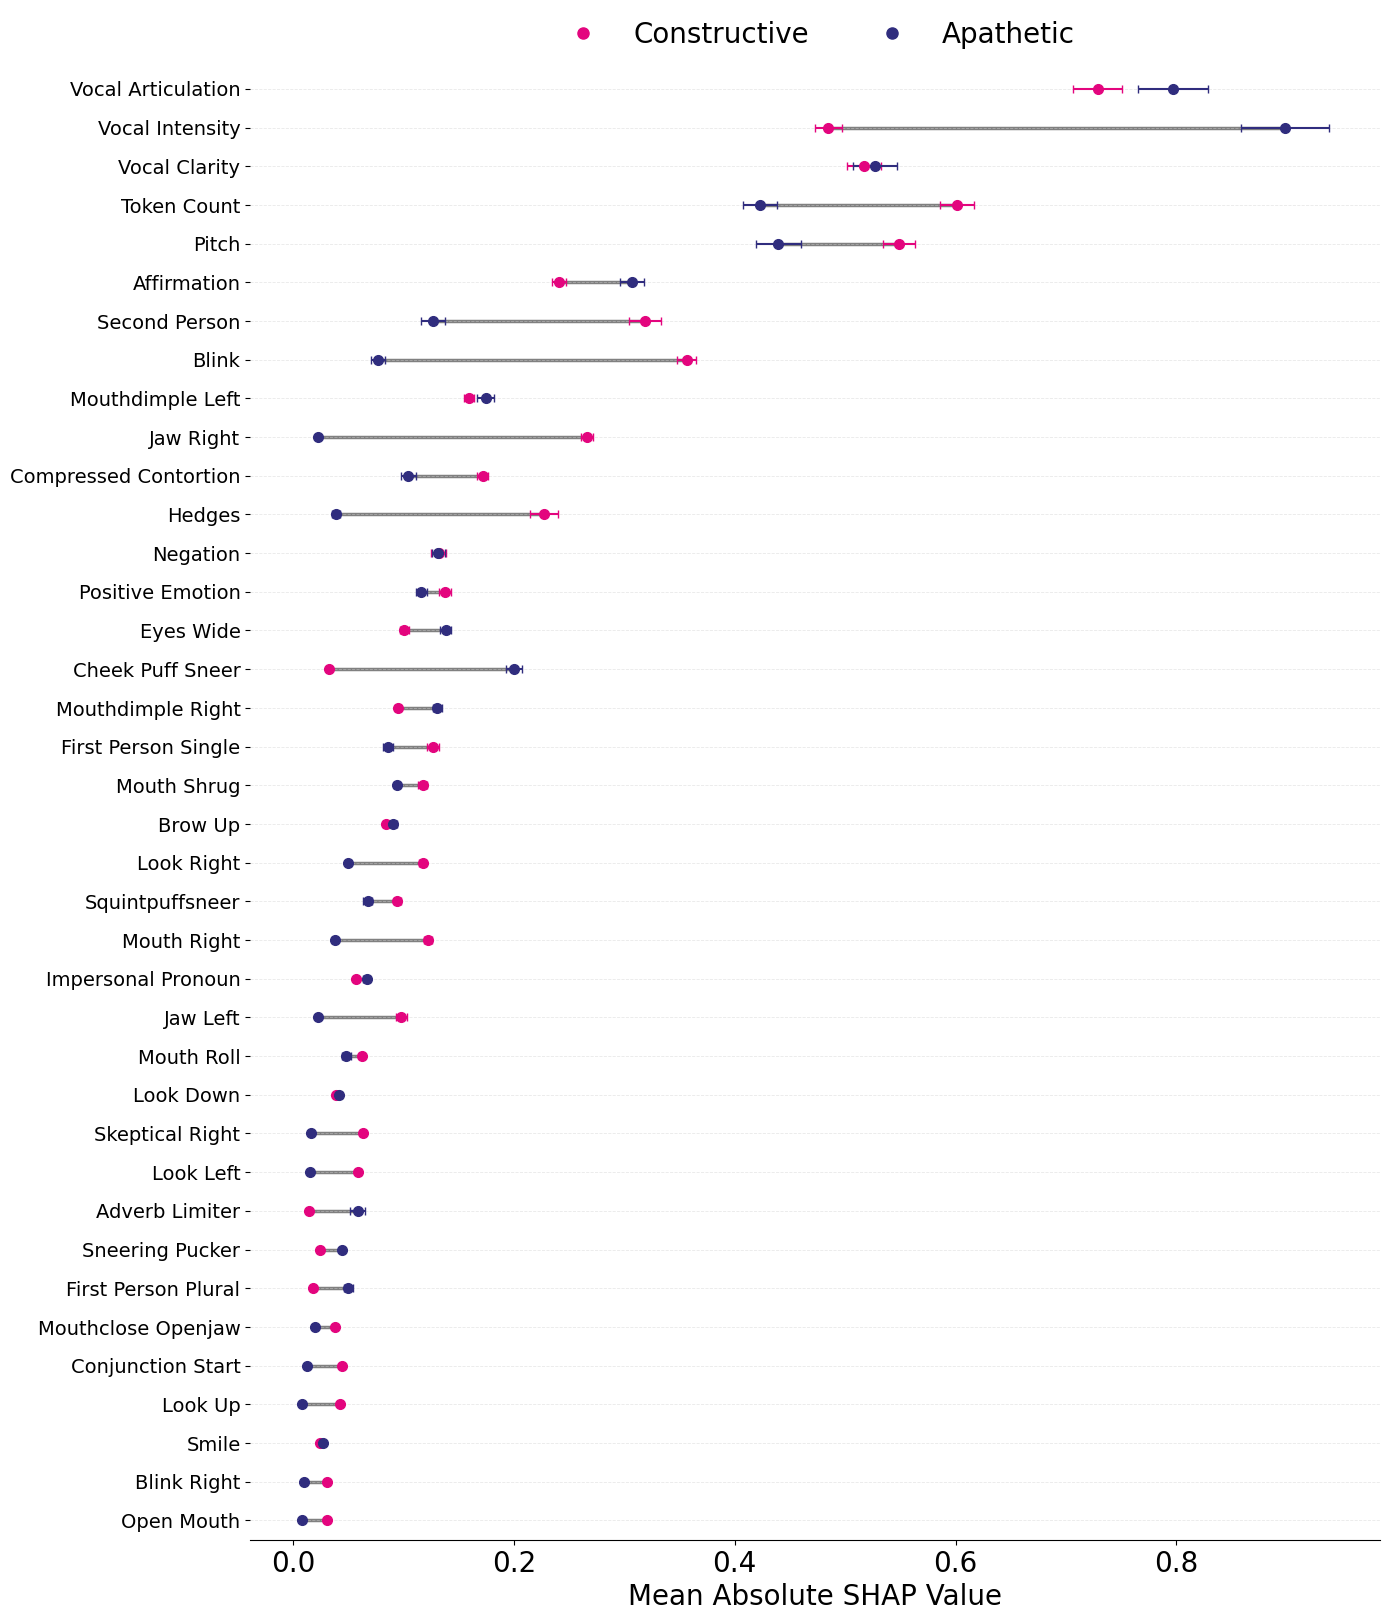

,Feature,Mean SHAP (Boot)_Constructive,Boot SE_Constructive,Mean SHAP (Boot)_Apathetic,Boot SE_Apathetic,Significant
0,Open Mouth,0.030945,0.001010,0.008252,0.000443,True
1,Blink Right,0.031032,0.001046,0.010454,0.001214,True
2,Smile,0.024083,0.000788,0.026815,0.001212,False
3,Look Up,0.042502,0.001638,0.008417,0.000526,True
4,Conjunction Start,0.044552,0.002066,0.013046,0.000808,True
5,Mouthclose Openjaw,0.038098,0.001156,0.019513,0.000906,True
6,First Person Plural,0.018456,0.001150,0.050175,0.003950,True
7,Sneering Pucker,0.024539,0.000697,0.044250,0.001664,True
8,Adverb Limiter,0.014710,0.001087,0.058594,0.006630,True
9,Look Left,0.059141,0.002499,0.015043,0.000767,True


In [11]:
segments = ['Constructive', 'Apathetic']
shap_dfs_by_category = generate_categorywise_bootstrapped_shap(df, segments, n_boot=1000)
plot_dumbbell_comparison(shap_dfs_by_category, "Constructive", "Apathetic")



Comparing across all segments

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:13:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:13:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv_imperial/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:13:26] WARNI

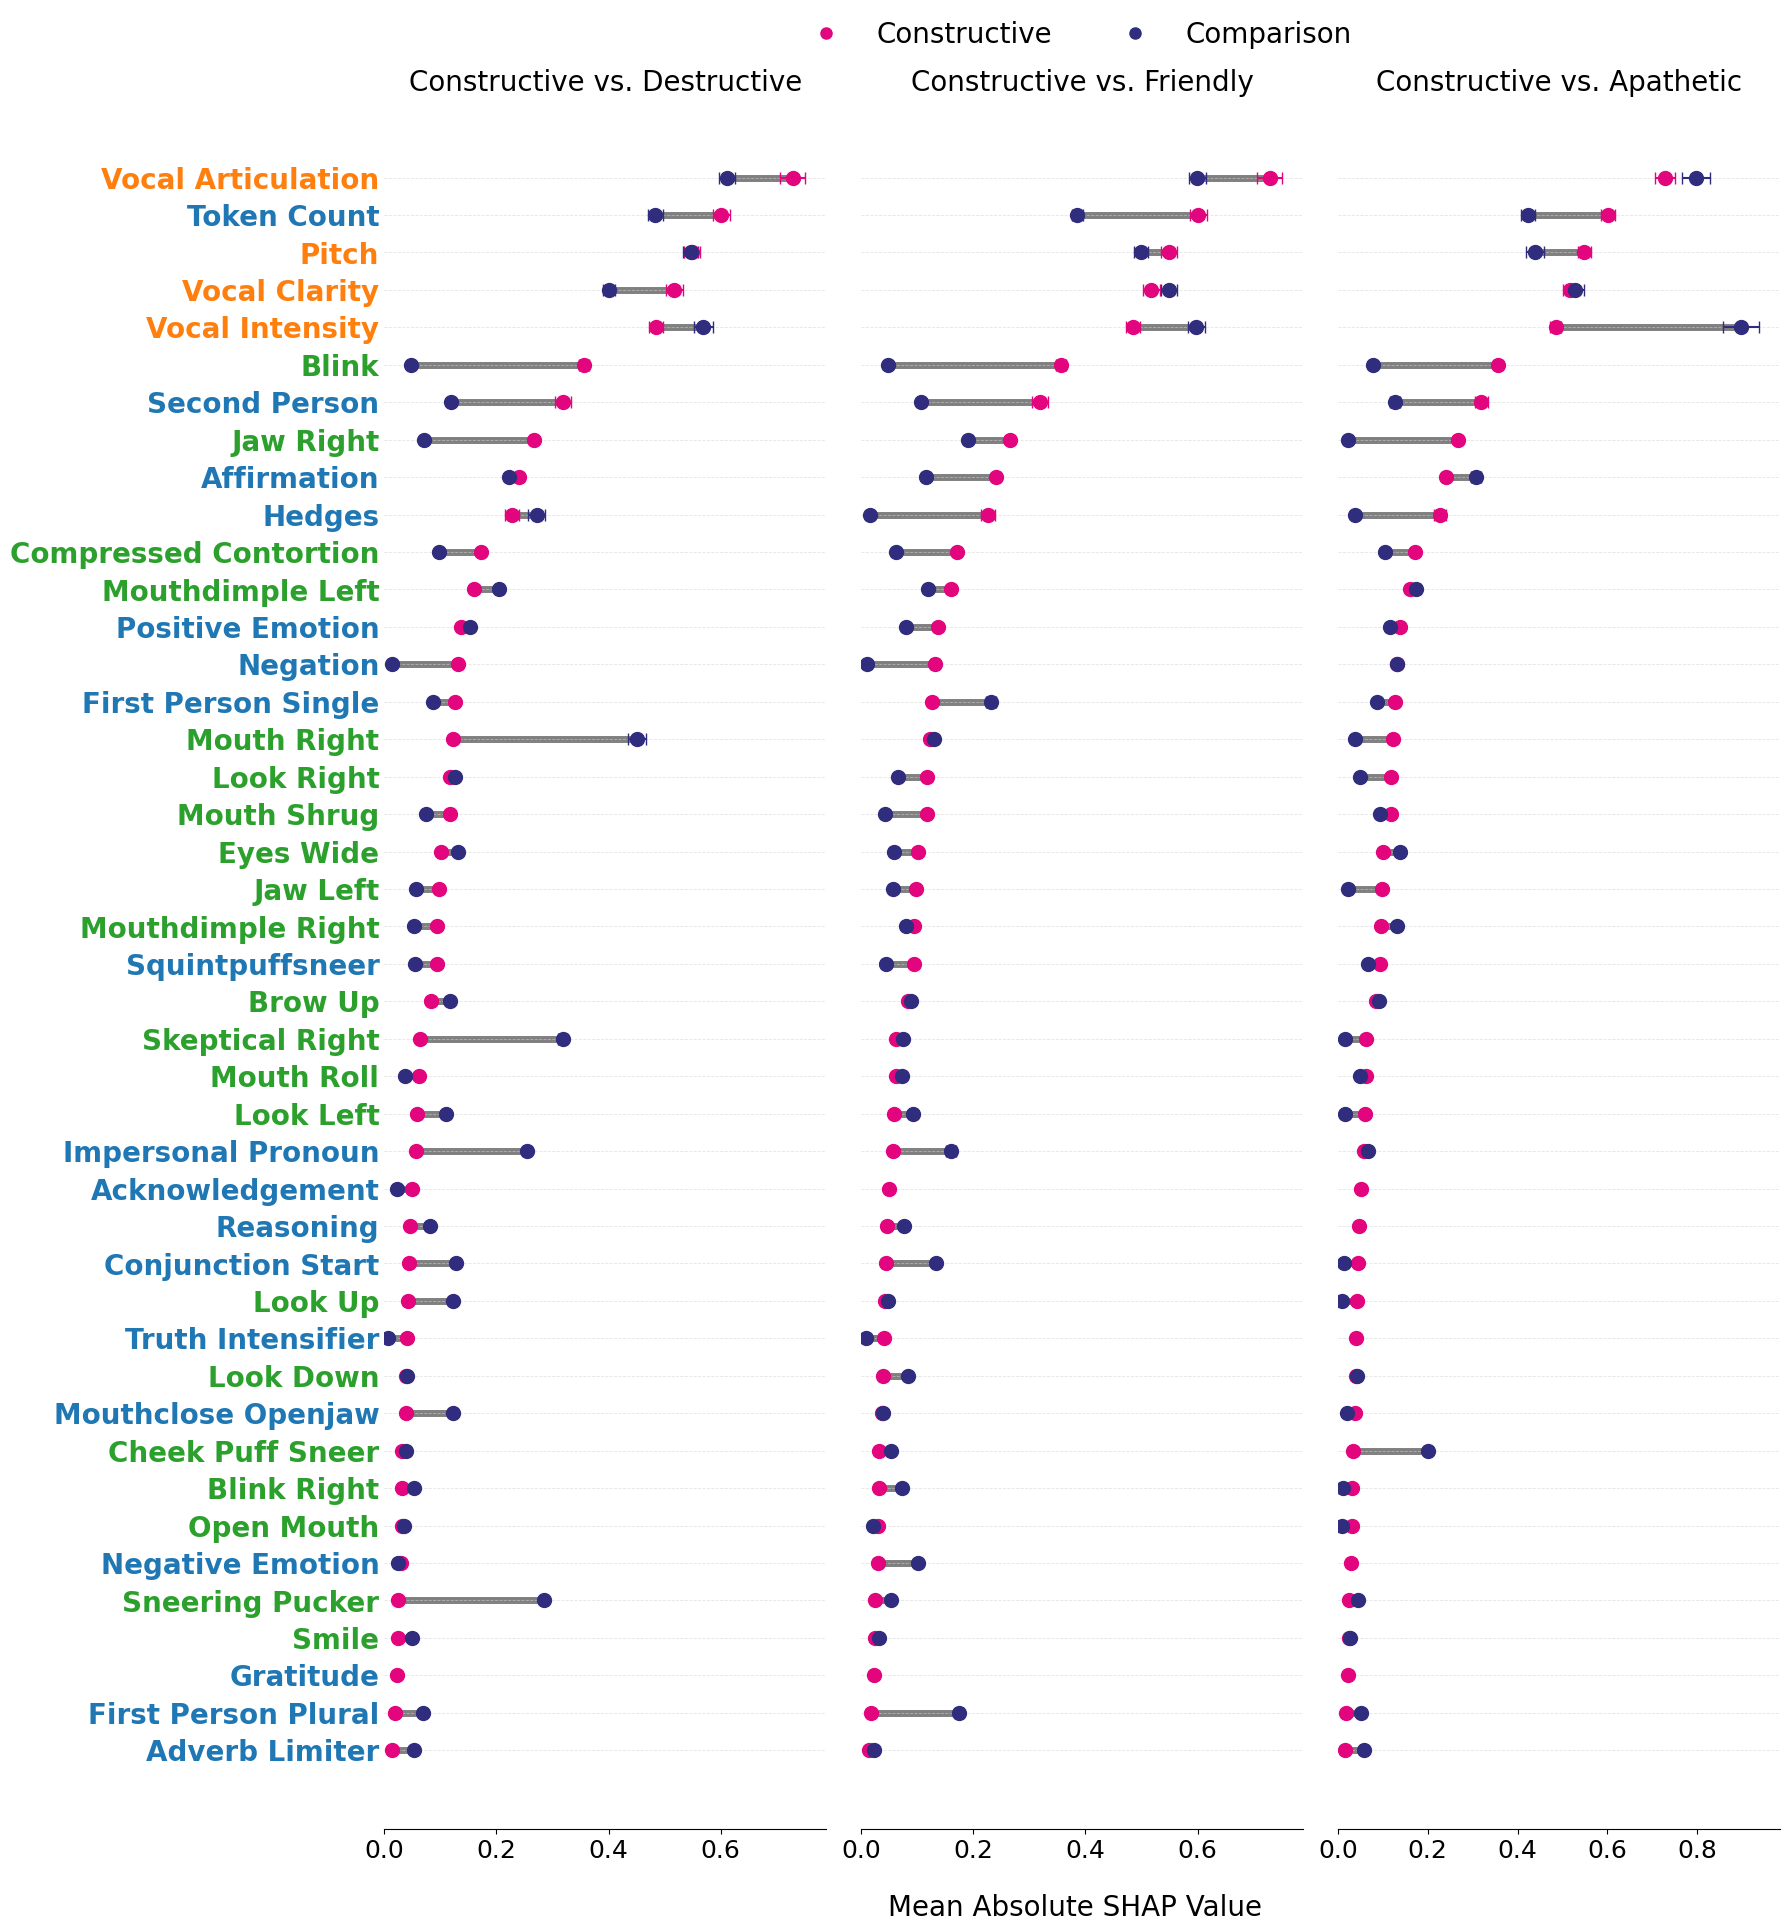

In [ ]:
segments = ['Constructive', 'Destructive','Friendly','Apathetic']
shap_dfs_by_category = generate_categorywise_bootstrapped_shap(df, segments, n_boot=1000)
full_results = plot_dumbbell_facets(shap_dfs_by_category, base_category="Constructive", compare_categories=["Destructive", "Friendly", "Apathetic"])
full_results.to_clipboard(index=False, header=True)
